In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from scipy.misc import derivative
from scipy.integrate import quadrature

from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rcParams['animation.html'] = 'html5'
matplotlib.rcParams['figure.figsize'] = (12, 10)
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['font.size'] = 16

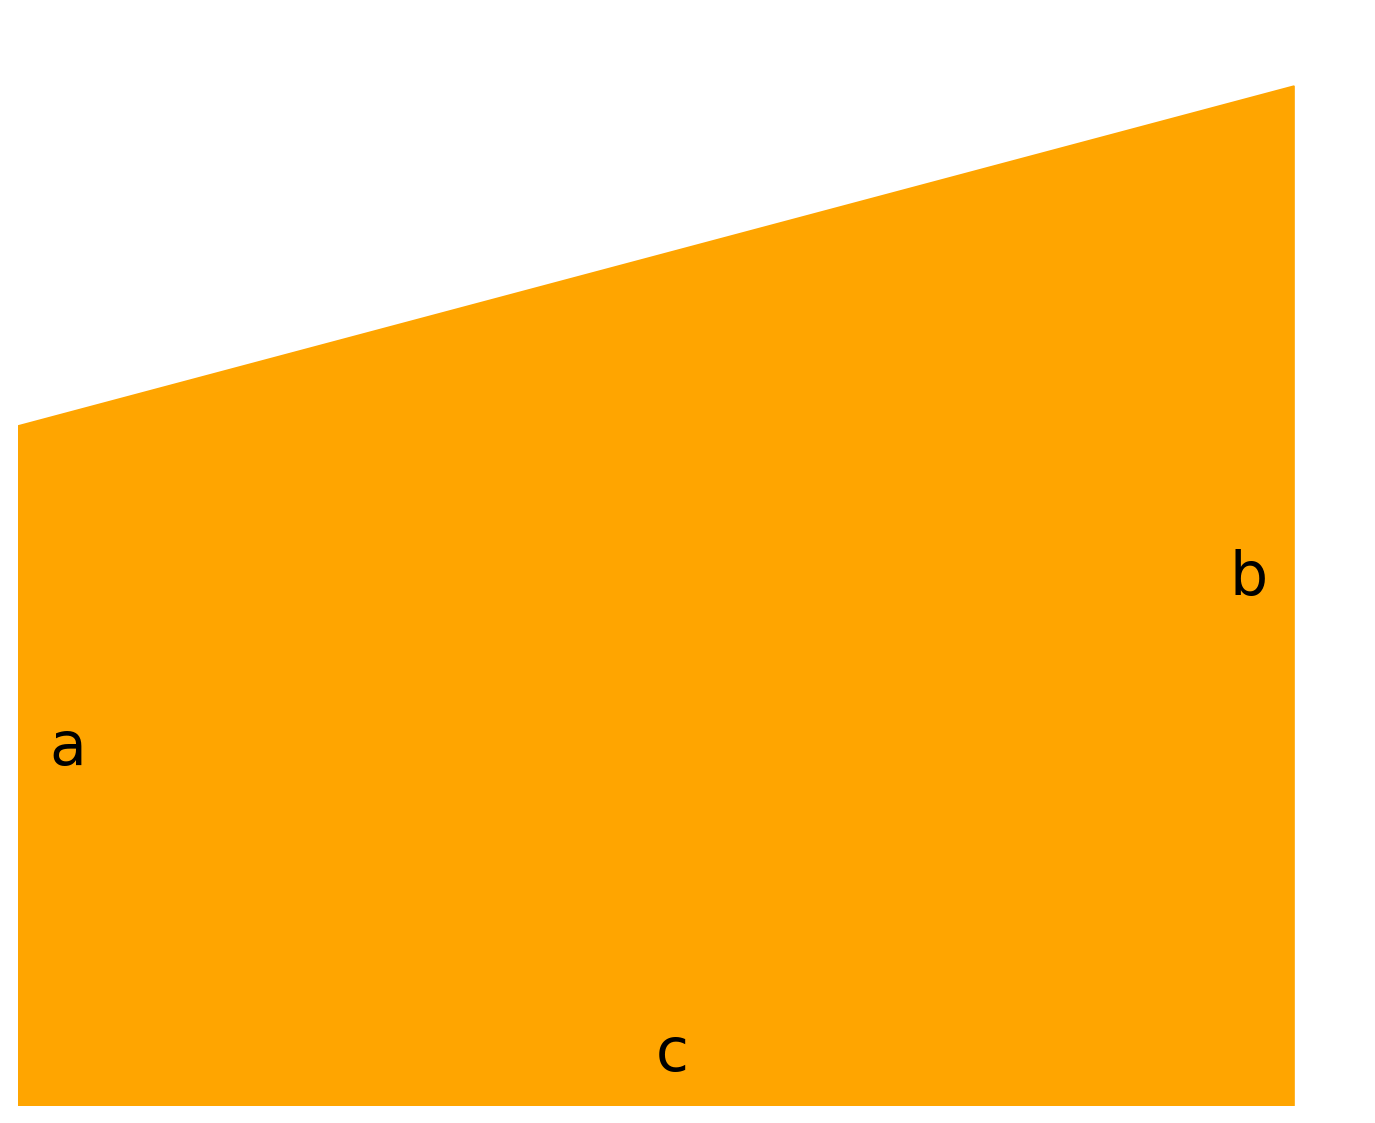

In [2]:
c = 4
a = 2
b = 3

def f(t): return a + (b-a)/c*t

fig = plt.figure()
ax = plt.gca()
ax.fill_between([0,c], [a,b], color="orange")
line, = ax.plot([-.2, c+.2], [f(-.2), f(c+.2)], "-", lw=3, 
               label=r"$f(t) = a + \frac{b-a}{c} t$")
ax.set_xlim(0, c+.2)
ax.set_ylim(0, b+.2)
ax.set_xlabel("$t$", fontsize=20)
ax.set_ylabel("$f(t)$", fontsize=20)
ax.annotate("c", (.5*c, .1), size=30)
ax.annotate("a", (.1, .5*a), size=30)
ax.annotate("b", (c-.2, .5*b), size=30)
legend = ax.legend(fontsize=30)
plt.savefig("trapezoid2.png")

line.set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis("off")
legend.set_visible(False)
plt.savefig("trapezoid1.png")

In [3]:
T = 5 # max time
n_frames = 100 # number of frames in movie (the greater, the smoother the movie)
ylim = (0, 22) # the extent of the y axis
dylim = (-10, 10) # the extent of the \dot y axis

In [4]:
# First set up the figure, the axis, and the plot element we want to animate
def motion(y, draw_slope=False):
    from scipy.misc import derivative

    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.set_xlim(0, T)
    ax1.set_ylim(ylim)
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$y$", rotation=0)
    ax1.grid()

    line,  = ax1.plot([], [], '-b', lw=2)
    slope, = ax1.plot([], [], '-g', lw=2)

    ax2.set_xlim(0, T)
    ax2.set_ylim(dylim)
    ax2.set_xlabel(r"$t$")
    ax2.set_ylabel(r"$\frac{dy}{dt}$", rotation=0)
    ax2.grid()

    dline,  = ax2.plot([], [], '-g', lw=2)
    #dvline, = ax2.plot([], [], '--k')

    global cline
    cline  = matplotlib.patches.ConnectionPatch(xyA=(2,2), xyB=(3,3), coordsA="data", coordsB="data",
                                                axesA=ax2, axesB=ax1, zorder=25)
    ax2.add_artist(cline)

    all_points = []
    deriv_points = []

    def init():
        return line, slope, cline

    def animate(i):
        global cline
        delta = .8
        t = float(i) / n_frames * T
        yy = y(t)

        all_points.append([t, yy])
        line.set_data([p[0] for p in all_points], [p[1] for p in all_points])
        #vline.set_data([t,t], [ylim[0], yy])

        v = derivative(y, t)
        slope.set_data([t-delta, t+delta], [yy-delta*v, yy+delta*v])
        deriv_points.append([t, v])
        dline.set_data([p[0] for p in deriv_points], [p[1] for p in deriv_points])
        #dvline.set_data([t,t], [v, dylim[1]])

        cline.remove()
        cline = matplotlib.patches.ConnectionPatch(xyA=(t, v), xyB=(t, yy),
                                                   coordsA="data", coordsB="data",
                                                   arrowstyle="<|-",
                                                   axesA=ax2, axesB=ax1, zorder=25)
        ax2.add_artist(cline)

        return line, slope, cline

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n_frames + 1, interval=T/n_frames*2000,
                                   blit=True, repeat=False)
    plt.close()

    return anim

In [5]:
# First set up the figure, the axis, and the plot element we want to animate
def motion_int(y, dy):
    from scipy.misc import derivative

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    ax1.set_xlim(0, T)
    ax1.set_ylim(ylim)
    ax1.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$y$", rotation=0)
    ax1.grid()

    TT = np.linspace(0, T, n_frames+1)
    YY = [y(t) for t in TT]
    line, = ax1.plot(TT, YY, '-b', lw=2)

    DY = [dy(t) for t in TT]

    ax2.set_xlim(0, T)
    ax2.set_ylim(dylim)
    ax2.set_xlabel(r"$t$")
    ax2.set_ylabel(r"$\frac{dy}{dt}$", rotation=0)
    ax2.grid()

    dline, = ax2.plot(TT, DY, '-g', lw=2)
    global area
    area = ax2.fill_between([], [], color="r")

    ax3.set_xlim(0, T)
    ax3.set_ylim(ylim)
    ax3.set_xlabel(r"$t$")
    ax3.set_ylabel(r"$A$", rotation=0)
    ax3.grid()

    AA = [quadrature(dy, 0, t)[0] for t in TT]

    Aline, = ax3.plot([], [], '-r', lw=2)

    global cline
    cline  = matplotlib.patches.ConnectionPatch(xyA=(2,2), xyB=(3,3), coordsA="data", coordsB="data",
                                                axesA=ax3, axesB=ax2, zorder=25)
    ax3.add_artist(cline)

    TT = []
    AA = []

    def init():
        return Aline, area

    def animate(i):
        global cline
        global area
        t = float(i) / n_frames * T
        TT.append(t)
        AA.append(quadrature(dy, 0, t)[0])

        Aline.set_data(TT, AA)
        area.remove()
        area = ax2.fill_between(TT, DY[:i+1], color='r')

        cline.remove()
        cline = matplotlib.patches.ConnectionPatch(xyA=(t, AA[i]), xyB=(t, 0),
                                                  coordsA="data", coordsB="data",
                                                  arrowstyle="<|-",
                                                  axesA=ax3, axesB=ax2, zorder=25)
        ax3.add_artist(cline)

        return Aline, area

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n_frames + 1, interval=T/n_frames*2000,
                                   blit=True, repeat=False)
    plt.close()

    return anim

In [6]:
ylim = [-5, 15]
dylim = [-5, 15]

def y(t):
    return t**3 - 7*t**2  + 12*t # t*(t-3)*(t-4)

def dy(t):
    return 3*t**2 - 7*2*t + 12
    #return derivative(y, t)

motion(y)

In [7]:
motion_int(y, dy)

In [8]:
def y(t):
    return 5 + t**3 - 7*t**2  + 12*t # t*(t-3)*(t-4)

motion_int(y, dy)